# 기본 셋팅

In [2]:
!pip install facenet_pytorch
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

     |████████████████████████████████| 1.9 MB 4.0 MB/s 


In [5]:
from google.colab import drive

drive.mount("/content/")

Mounted at here


# MTCNN의 기본

torch.Size([3, 160, 160])

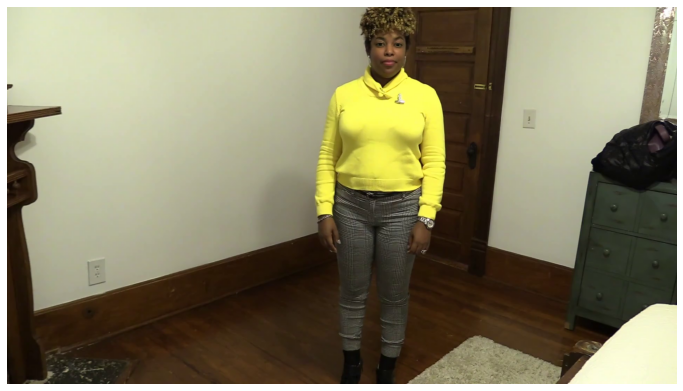

In [57]:
image_path = "/content/here/MyDrive/AI School/Project 02 Computer Vision /input_videos/agqphdxmwt.mp4"

mtcnn = MTCNN(select_largest=False, device='cuda')

# 이미지를 불러옴
# "ret" 은 카메라 프레임에 대한참거짓 값.
# frame 은 ("cap"을 통해) 카메라의 다음 프레임을 받음
v_cap = cv2.VideoCapture(image_path)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')

# Detect face
face = mtcnn(frame)
face.shape

# 이미지 정규화 안 하기

(-0.5, 159.5, 159.5, -0.5)

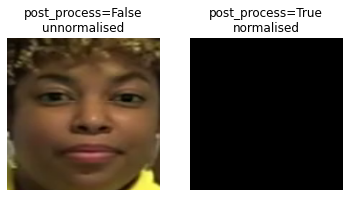

In [31]:
# 안면인식기 생성
## post_process=False   
##   정규화를 시행하지 않음 (아래 출력물 비교를 참고).
mtcnn_unnormal = MTCNN(select_largest=False, post_process=False, device='cuda:0')
mtcnn_normal = MTCNN(select_largest=False, post_process=True, device='cuda:0') # In fact, no need to set it True cause it's the deafult value. 

# 안면을 인식
face_unnormal = mtcnn_unnormal(frame)
face_normal = mtcnn_normal(frame)

# 시각화
fig, axes = plt.subplots(1, 2)

axes[0].imshow(face_unnormal.permute(1, 2, 0).int().numpy())
axes[0].set_title('post_process=False\nunnormalised')
axes[0].axis('off')
axes[1].set_title('post_process=True\nnormalised')
axes[1].imshow(face_normal.permute(1, 2, 0).int().numpy())
axes[1].axis('off')

# 마진 조정
_"Depending on your downstream processing and **how fakes can be identified**, you may want to add more (or less) of a margin around the detected faces. This is controlled using the margin argument."_

- 마진 조정은 가짜 얼굴 식별에 도움이 될 수 있는 것으로 보인다.

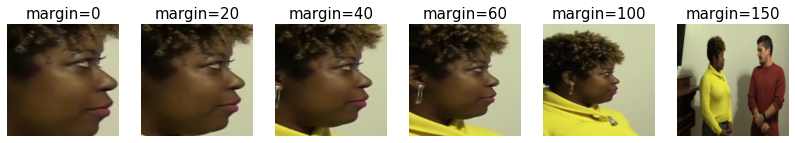

In [114]:
# 안면인식기 생성
## margin=n     HTML처럼 마진값 정해 줌. 

MODELS = []
FACES = []
MARGINS = [0, 20, 40, 60, 100, 150]

def set_margin(num):
    mtcnn = MTCNN(margin=num, select_largest=False, post_process=False, device='cuda:0')
    return mtcnn

for i in range(len(MARGINS)):
    MODELS.append(set_margin(MARGINS[i]))
    FACES.append(MODELS[i](frame))
    
# 시각화
figure, axes = plt.subplots(1, 6, figsize=(14,14))

PERMUTED_FACES  = []

for face in FACES:
    face = face.permute(1, 2, 0).int().numpy()
    PERMUTED_FACES.append(face)

for i in range(len(PERMUTED_FACES)):
    axes[i].imshow(PERMUTED_FACES[i])
    axes[i].set_title(f'margin={MARGINS[i]}', fontsize=15)
    axes[i].axis('off')

# 하나의 이미지에 얼굴이 여러개일 때
- ```keep_all=True``` 모든 얼굴(다수 개의 얼굴)을 다 인식.
- for 문을 포함한 아래의 코드에 얼굴이 한개인 이미지를 넣으면 iterability 문제로 오류 날 수 있음 ㄷㄷ

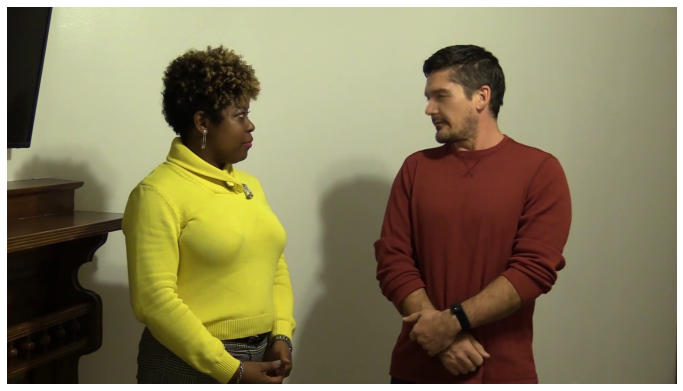

faces shape:  torch.Size([2, 3, 160, 160])


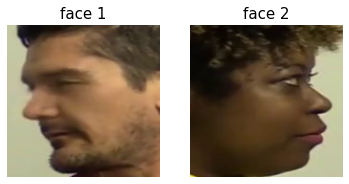

In [85]:
# 안면인식기 생성
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

image_dir = '/content/here/MyDrive/AI School/Project 02 Computer Vision /input_videos/'

multiple_faces_video = image_dir + "aapnvogymq.mp4"

# 이미지를 불러옴.
v_cap = cv2.VideoCapture(multiple_faces_video)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# 안면을 인식
faces = mtcnn(frame)

# 시각화
print('faces shape: ', faces.shape)
fig, axes = plt.subplots(1, len(faces))
i = 0
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.set_title(f'face {i + 1}', fontsize=15)
    ax.axis('off')
    i += 1
fig.show()

# 배치 인식

  0%|          | 0/300 [00:00<?, ?it/s]

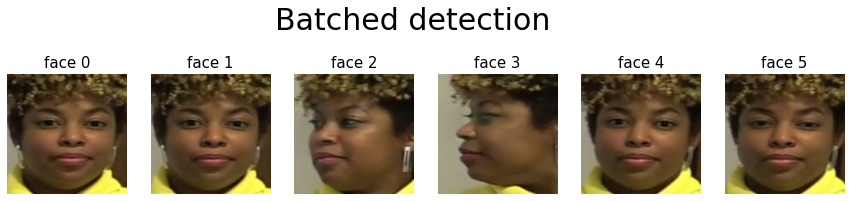

In [166]:
# 안면인식기 생성
mtcnn = MTCNN(margin=30, keep_all=True, post_process=False, device='cuda:0')

# 비디오 불러옴
v_cap = cv2.VideoCapture(image_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))  # frame count = 300

# 비디오 looping. 한 배치에서 프레임 여러개 획득
frames = []     # 총 6개의 PIL.Image.Image 요소가 들어 있음.

for i in tqdm(range(v_len)):
    
    # 프레임 불러오기
    success = v_cap.grab()
    if i % 50 == 0:
        success, frame = v_cap.retrieve()
    else:
        continue
    if not success:
        continue
        
    # 배치에 추가해 줌. 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))

# 배치의 얼굴을 인식
faces = mtcnn(frames)

fig, axes = plt.subplots(1, len(faces), figsize=(15, 15))
for i, frame_faces in enumerate(faces):
    for j, face in enumerate(frame_faces):
        axes[i].imshow(face.permute(1, 2, 0).int().numpy())
        axes[i].set_title(f'face {i}', fontsize=15)
        axes[i].axis('off')
plt.subplots_adjust(top=1.6)
fig.suptitle('Batched detection', fontsize=30)
fig.show()

In [165]:
# overview
print('video frame count: ', v_len)
print('frames length: ', len(frames))
print('frames type: ', type(frames[0]))
print('frames[0] ', frames[0])
print(frames[0])

video frame count:  300
frames length:  6
frames type:  <class 'PIL.Image.Image'>
frames[0]  <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F261E9E7610>
<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F261E9E7610>


  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

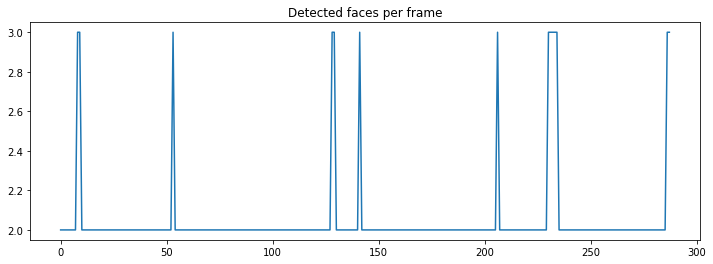

In [171]:
# 비디오 불러옴
v_cap = cv2.VideoCapture(multiple_faces_video)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 비디오 looping
batch_size = 16
frames = []
faces = []

for _ in tqdm(range(v_len)):
    
    # 프레임 불러옴
    success, frame = v_cap.read()
    if not success:
        continue
        
    # 배치에 추가
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))
    
    # 배치가 꽉 차면 얼굴을 인식하고 배치를 리셋. 
    if len(frames) >= batch_size:
        faces.extend(mtcnn(frames))
        frames = []

plt.figure(figsize=(12, 4))
plt.plot([len(f) for f in faces])
plt.title('Detected faces per frame');

# Bounding Boxes and Facial Landmarks

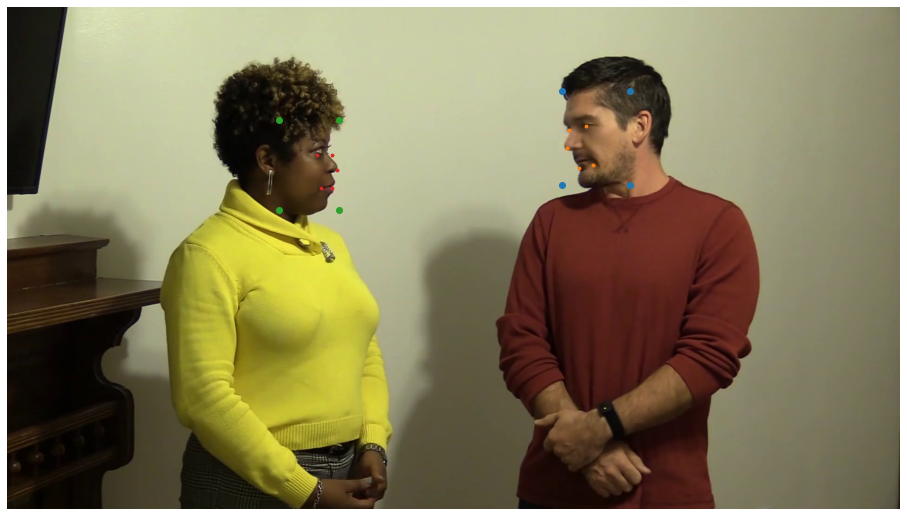

In [175]:
# 안면인식기 생성
mtcnn = MTCNN(keep_all=True, device='cuda:0')

# 이미지를 불러와 출력
v_cap = cv2.VideoCapture(multiple_faces_video)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

# 안면을 인식
boxes, probs, landmarks = mtcnn.detect(frame, landmarks=True)

# 시각화
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(frame)
ax.axis('off')

for box, landmark in zip(boxes, landmarks):
    ax.scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]))
    ax.scatter(landmark[:, 0], landmark[:, 1], s=8)
fig.show()

# 더 연습이 필요한 함수들
- fig, axes = plt.subplots(1, 2)
- fig.suptitle('Set a single main title for subplots') 

# 참고문헌
- https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
- https://www.geeksforgeeks.org/how-to-set-a-single-main-title-for-all-the-subplots-in-matplotlib/

In [ ]:
fig.suptitle('Set a single main title for subplots', fontsize=30)

# 오류 노트


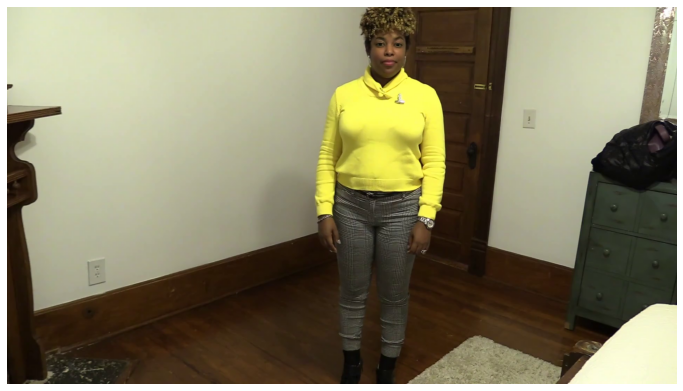

TypeError: ignored

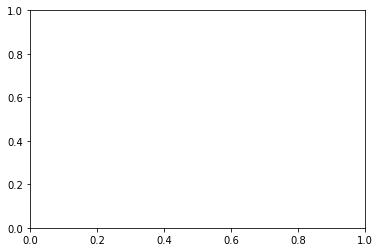

In [63]:
# 안면인식기 생성
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

multiple_faces = "/content/here/MyDrive/AI School/Project 02 Computer Vision /ASIAN Face recognition test/UNKNOWN/IU6 super tricky.jpg"

# 이미지를 불러와 출력
v_cap = cv2.VideoCapture(image_path)
success, frame = v_cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = Image.fromarray(frame)

plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')
plt.show()

# 안면을 인식
faces = mtcnn(frame)

# 시각화
fig, axes = plt.subplots(1, len(faces))
for face, ax in zip(faces, axes):
    ax.imshow(face.permute(1, 2, 0).int().numpy())
    ax.axis('off')
fig.show()

## print('dtype: ', type(faces))
print('shape: ', faces.shape)
print(faces)